# HW 6
ENGN2912V

Seokkee Min

## P1 - CNN

In [1]:
import jax
from jax.example_libraries import stax, optimizers
from jax import numpy as jnp
from jax import jit, grad, vmap, random, value_and_grad
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
train_path = "/gpfs/home/smin24/ENGN2912V/HW_L6/mnist_train.csv"
test_path = "/gpfs/home/smin24/ENGN2912V/HW_L6/mnist_test.csv"
x_train = np.loadtxt(train_path, delimiter = ',', skiprows=1, usecols=range(1,785))
x_test = np.loadtxt(test_path, delimiter = ',', skiprows=1, usecols=range(1,785))

In [3]:
y_train = np.loadtxt(train_path, delimiter = ',', skiprows=1, usecols=0)
y_test = np.loadtxt(test_path, delimiter = ',', skiprows=1, usecols=0)

In [4]:
np.shape(x_train), np.shape(x_test)

((60000, 784), (10000, 784))

In [5]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_test /= 255.0
x_train /= 255.0

classes = jnp.unique(y_train)

In [6]:
conv_init, conv_apply = stax.serial(
    stax.Conv(32,(3,3), padding = "SAME"),
    stax.Relu,
    stax.Conv(16, (3,3), padding = "SAME"),
    stax.Relu,
    
    stax.Flatten,
    stax.Dense(len(classes)),
    stax.Softmax
)

In [2]:
rng = jax.random.PRNGKey(1234)

2023-04-26 22:04:06.992168: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12653035520
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
weights = conv_init(rng, (18,28,28,1))
weights = weights[1]

for w in weights:
    if w:
        w, b = w
        print("Weights : {}, Biases : {}".format(w.shape, b.shape))

Weights : (3, 3, 1, 32), Biases : (1, 1, 1, 32)
Weights : (3, 3, 32, 16), Biases : (1, 1, 1, 16)
Weights : (12544, 10), Biases : (10,)


In [8]:
preds = conv_apply(weights, x_train[:5])

In [9]:
preds

Array([[0.09970718, 0.08787042, 0.08216777, 0.11233684, 0.10282524,
        0.10359077, 0.10885791, 0.10094956, 0.10177766, 0.09991664],
       [0.09815039, 0.08544517, 0.08750093, 0.10332955, 0.10838366,
        0.09500911, 0.11133257, 0.09582874, 0.10590765, 0.10911224],
       [0.10432425, 0.10296273, 0.08341178, 0.11053631, 0.10947052,
        0.0924192 , 0.10321891, 0.09241705, 0.10337016, 0.09786902],
       [0.0978803 , 0.10050037, 0.08396979, 0.10295038, 0.10739256,
        0.09288935, 0.11269365, 0.09960553, 0.10745761, 0.09466055],
       [0.083104  , 0.11387152, 0.09326962, 0.09825166, 0.09160949,
        0.08975831, 0.10821015, 0.10538024, 0.11558762, 0.10095735]],      dtype=float32)

In [10]:
def CrossEntropyLoss(weights, input_data, actual):
    preds = conv_apply(weights, input_data)
    one_hot_actual = jax.nn.one_hot(actual, num_classes = len(classes))
    log_preds = jnp.log(preds)
    return - jnp.sum(one_hot_actual * log_preds)

In [11]:
def TrainModelInBatches(X, Y, epochs, opt_state, batch_size=32):
    for i in range(1, epochs+1):
        batches = jnp.arange((X.shape[0]//batch_size)+1) ### Batch Indices

        losses = [] ## Record loss of each batch
        for batch in batches:
            if batch != batches[-1]:
                start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
            else:
                start, end = int(batch*batch_size), None

            X_batch, Y_batch = X[start:end], Y[start:end] ## Single batch of data

            loss, gradients = value_and_grad(CrossEntropyLoss)(opt_get_weights(opt_state), X_batch,Y_batch)

            ## Update Weights
            opt_state = opt_update(i, gradients, opt_state)

            losses.append(loss) ## Record Loss

        print("CrossEntropyLoss : {:.3f}".format(jnp.array(losses).mean()))

    return opt_state

In [12]:
seed = jax.random.PRNGKey(1234)
lr = jnp.array(1e-4)
epochs = 25
batch = 256

weights = conv_init(rng, (batch, 28, 28, 1))
weights = weights[1]

opt_init, opt_update, opt_get_weights = optimizers.sgd(lr)
opt_state = opt_init(weights)

final_opt_state = TrainModelInBatches(x_train, y_train, epochs, opt_state, batch_size=batch)

CrossEntropyLoss : 161.442
CrossEntropyLoss : 89.797
CrossEntropyLoss : 80.723
CrossEntropyLoss : 73.774
CrossEntropyLoss : 66.493
CrossEntropyLoss : 57.924
CrossEntropyLoss : 48.553
CrossEntropyLoss : 40.021
CrossEntropyLoss : 33.481
CrossEntropyLoss : 28.833
CrossEntropyLoss : 25.516
CrossEntropyLoss : 23.055
CrossEntropyLoss : 21.159
CrossEntropyLoss : 19.653
CrossEntropyLoss : 18.422
CrossEntropyLoss : 17.392
CrossEntropyLoss : 16.514
CrossEntropyLoss : 15.750
CrossEntropyLoss : 15.075
CrossEntropyLoss : 14.471
CrossEntropyLoss : 13.924
CrossEntropyLoss : 13.425
CrossEntropyLoss : 12.966
CrossEntropyLoss : 12.539
CrossEntropyLoss : 12.143


In [13]:
def MakePredictions(weights, input_data, batch_size=32):
    batches = jnp.arange((input_data.shape[0]//batch_size)+1) ### Batch Indices

    preds = []
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch = input_data[start:end]

        if X_batch.shape[0] != 0:
            preds.append(conv_apply(weights, X_batch))

    return preds

In [15]:
test_preds = MakePredictions(opt_get_weights(final_opt_state), x_test, batch_size=batch)

test_preds = jnp.concatenate(test_preds).squeeze() ## Combine predictions of all batches

test_preds = jnp.argmax(test_preds, axis=1)

train_preds = MakePredictions(opt_get_weights(final_opt_state), x_train, batch_size=batch)

train_preds = jnp.concatenate(train_preds).squeeze() ## Combine predictions of all batches

train_preds = jnp.argmax(train_preds, axis=1)

test_preds[:5], train_preds[:5]

(Array([7, 2, 1, 0, 4], dtype=int32), Array([5, 0, 4, 1, 9], dtype=int32))

In [20]:
from sklearn.metrics import accuracy_score

print("Train Accuracy : {:.3f}".format(accuracy_score(y_train, train_preds)))
print("Test  Accuracy : {:.3f}".format(accuracy_score(y_test, test_preds)))

Train Accuracy : 0.988
Test  Accuracy : 0.981


In [22]:
from sklearn.metrics import classification_report

print("Test Classification Report ")
print(classification_report(y_test, test_preds))

Test Classification Report 
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.97      0.98      0.98      1032
         3.0       0.97      0.99      0.98      1010
         4.0       0.98      0.99      0.99       982
         5.0       0.97      0.99      0.98       892
         6.0       0.99      0.97      0.98       958
         7.0       0.98      0.97      0.98      1028
         8.0       0.98      0.97      0.98       974
         9.0       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



I built a CNN with two sets of Convolution and ReLU layers, and employed padding (="SAME"). With this, I was able to achieve approx 98% training and testing accuracy (0.988 and 0.981, respectively) after 25 training epochs.

## P2 - Runge Func

In [30]:
def runge(x):
    y = 1/(1+25*x**2)
    return y

def x_uni(n, lb, ub):
    x = jnp.linspace(lb, ub, n, dtype=np.float32)
    return x

def get_random_layer_params(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = 1/(jnp.sqrt(m+n)) * random.normal(w_key, (n, m))
    biases = jnp.zeros((n,)) 
    return weights, biases

def get_init_network_params(sizes, ran_key):
    keys = random.split(ran_key, len(sizes))
    return [get_random_layer_params(m, n, k) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def feedforward_prediction(params, x):     
    for w, b in params[:-1]:
        outputs = jnp.dot(w, x) + b  
        x = jax.nn.relu(outputs)  
    w_final, b_final = params[-1] 
    final_outputs = jnp.dot(w_final, x) + b_final 
    return final_outputs  

batched_prediction = vmap(feedforward_prediction, in_axes=(None, 0))

@jit
def mse_loss(params, x, y):
    preds = batched_prediction(params, x)
    diff = preds - y
    return jnp.sum(diff*diff)/preds.shape[0]

@jit
def update(params, x, y, learning_rate):
    l, grads = value_and_grad(mse_loss)(params, x, y)
    return [(w - learning_rate * dw, b - learning_rate * db) 
            for (w, b), (dw, db) in zip(params, grads)], l

i=0 and loss=Array(0.1564158, dtype=float32)

i=3000 and loss=Array(0.14473957, dtype=float32)

i=6000 and loss=Array(0.13482127, dtype=float32)

i=9000 and loss=Array(0.1264401, dtype=float32)

i=12000 and loss=Array(0.1193567, dtype=float32)

i=15000 and loss=Array(0.11337046, dtype=float32)



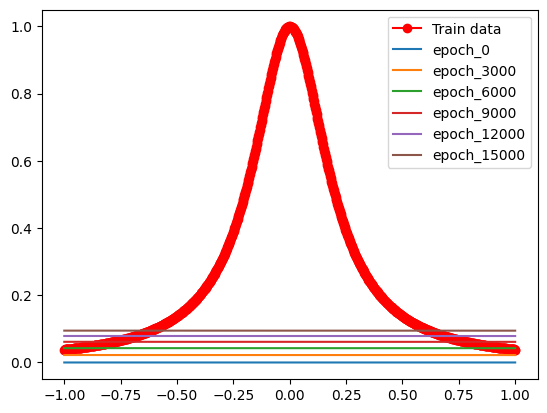

In [57]:
SEED = 1234
key = random.PRNGKey(SEED)
Niter = 15000
lr = 1e-05

num_features = 1
# num_traget = 1
num_batches = 1000
layers = [1] + [4]*8 + [1]
ran_key, func_key = random.split(key)
params = get_init_network_params(layers, ran_key)

x_train = x_uni(num_batches, -1, 1)
x_train = x_train.reshape((num_batches, num_features))
y_train = runge(x_train)
y_train = y_train.reshape((num_batches, num_features))

train_batch = 5000

x_pred = x_uni(train_batch, -1, 1)
x_pred = x_pred.reshape((train_batch, num_features))

L = np.zeros(Niter+1)

plt.plot(x_train, y_train, "-ro", label="Train data")

for i in range(0, Niter+1):
    params, loss = update(params, x_train, y_train, lr)
    L[i] = loss
    if i % 3000 == 0:
        print(f"{i=} and {loss=}\n")
        y_pred = batched_prediction(params, x_pred)
        y_pred = y_pred.reshape((train_batch, num_features))
        plt.plot(x_pred, y_pred, label = "epoch_" + str(i))
plt.legend()
        

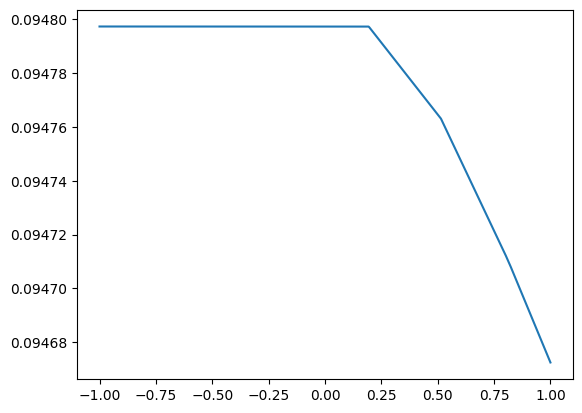

In [58]:
y_pred = batched_prediction(params, x_pred)
y_pred = y_pred.reshape((train_batch, num_features))
plt.plot(x_pred, y_pred, label = "prediction")

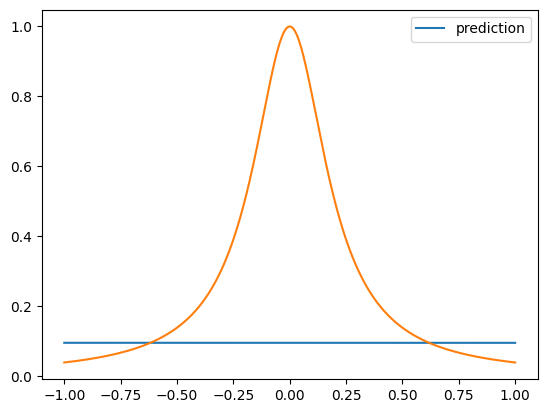

In [59]:
plt.plot(x_pred, y_pred, label = "prediction")
plt.plot(x_train, y_train)
plt.legend()

From epoch 0 to 15000, it appears that the output of the neural network (NN) is a constant value starting at zero, and moving up as the number of epochs increase. By removing the scaling due to the Runge function that the NN is trying to approximate, we can see that the output of the NN resembles its basis function (ReLu), but it's y-values barely change over the range of x.

This phenomena is described in Lecture 5 as dying ReLU networks and collapse, where in most cases the bias in the last layer is the mean value of the function y(x), and the composition of all the previous layers is equivalent to a zero function, and the gradient vanishes. For a ReLU NN of L-layers with a constant number of neurons per layer, the probability that the NN will die increases as L increases. Because we have a very shallow and deep network, the probability that the NN will collapse is non-negligible.